# Convolutional neural networks for artistic style transfer

This iPython notebook is an implementation of a popular paper ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) that demonstrates how to use neural networks to transfer artistic style from one image onto another. It is meant to go along with a [related blog post](https://harishnarayanan.org/writing/artistic-style-transfer/) that provides more context, and explains a lot of the theory behind the steps that follow.

The implementation below is not meant to be a standalone way to run this sort of style transfer in practice. If you're interested in doing so, you should take a look at the companion file `neural_style_transfer.py` that's more streamlined for more general and batch use. Both these files require the Python packages specified in `requirements.txt` to be installed to work.

There will be a companion blog post and project coming soon in the future that implements a much faster version of this algorithm ([Johnson et al., 2016](todo)) and wraps it in a webapp, a la Prisma.

In [1]:
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg19 import VGG19

Using TensorFlow backend.


## Load and preprocess the content and style images

Our first task is to load the content and style images. Note that the content image we're working with is not particularly high quality, but the output we'll arrive at the end of this process still looks really good.

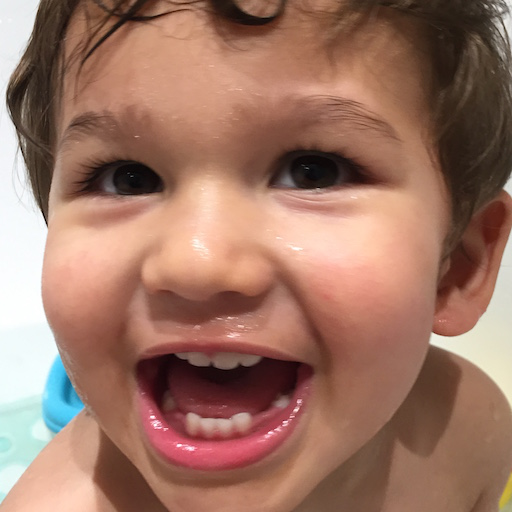

In [2]:
height = 512
width = 512

content_image_path = 'images/hugo.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

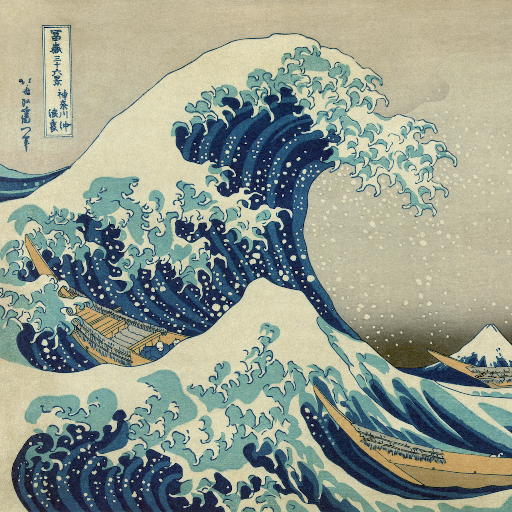

In [3]:
style_image_path = 'images/wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

Then, we convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic width x height x 3 dimensions) so that we can later concatenate the representations of these two images into a common data structure.

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print content_array.shape

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print style_array.shape

(1, 512, 512, 3)
(1, 512, 512, 3)


Before we proceed much further, we need to massage this input data to match what was used in the VGG paper. For this, we need to perform two transformations:

1. Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
2. Flip RGB ordering in the tensor we have to BGR. Because for some reason that's what the VGG paper chose to use.

In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

We finally use these arrays to define variables in the Keras backend (TensorFlow session). We also introduce a placeholder variable to store the generated image that retains the content of the content image while using the style of the style image.

In [10]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [12]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Start with a model pre-trained for image classification

As described by [Gatys et al. (2015)](todo), we start our journey with the *feature spaces* provided by the 16 convolutional and 5 pooling layers of the 19 layer VGG Network ([Simonyan and Zisserman, 2015](todo)). These are the elements marked in green in the table below.

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

This is trivial to do in Keras because it comes with a set of pretrained models. Note that by setting `include_top=False` in the code below, we don't include any of the fully connected layers.

In [7]:
model = VGG19(weights='imagenet', include_top=False)

As is clear from the table above, this model has a lot of layers. Keras has its own names for these layers and the blocks within them. Let's get these names so that we can easily refer to the individual blocks we want to later access in constructing our loss function for style transfer.

In [8]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_1:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool:0' shape=(?, ?, ?, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_2:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_3:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_1:0' shape=(?, ?, ?, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_4:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_5:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_6:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'Relu_7:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_2:0' shape=(?, ?, ?, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_8:0' shape=(?, ?, ?, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_9:0' shape=(?, ?, ?, 512) dtype=float32>,
 'block4_conv

If you stare at the list above, you'll convince yourself we covered all items we wanted in the table (the cells marked in green).

The crux of Gatys et al. (2015) (merged with ideas from Johnson et al. (2016)) is that the loss function for the style transfer problem can be broken into three distinct parts: the content loss, the style loss and the total variation loss.

### The content loss

In [9]:
layers
content_features = layers['block2_conv2'] # From Johnson, block4_conv2 in Keras, not defined in Gatys?

# base_image_features = layer_features[0, :, :, :]
# combination_features = layer_features[2, :, :, :]

Then, we convert this image data into a tensor (multi-dimensional array) that's suitable for processing by Keras' VGG19 model.

### Notes

The VGG network was originally created for image classification. But it turns out that when trained for this purpose, the feature spaces extracted from intermediate layers allows one to separate aspects of an image's content from its style.

The general idea behind Gatys et al. (2015) is that we're going to setup an optimisation problem that aims to solve for a *combination image* that contains the content of the content image, while having the style of the style image. This combination image begins its life as a random collection of pixels, and we use L-BFGS to iteratively improve upon it.